In [65]:
import torch
import torch.nn.functional as F
from torch.autograd import Function
import torchvision.models as models
from custom_models.cnn import CNN
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [66]:
# Load a pre-trained model (for example, ResNet-50)
# Step 1: Define or load the model architecture
model = CNN(in_channels=1, num_classes=4)

# Let's say you have a ResNet model (this can be any model you used during training)
# Step 2: Load the trained model's state_dict from the .pth file
model_path = '../best_basic_cnn.pth'  # Specify the path to your .pth file
model.load_state_dict(torch.load(model_path))

# Step 3: Set the model to evaluation mode (important for inference)
model.eval()

/var/folders/kc/22nrcfyj26bfczb8g410jks40000gn/T/ipykernel_3259/3811113597.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=4, bias=True)
)

In [67]:
# Hook for the gradients of the target layer
class FeatureExtractor:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def __call__(self, x):
        outputs = []
        gradients = None
        # Forward pass through the layers
        for name, module in self.model._modules.items():
            if name == 'fc1':
                x = torch.flatten(x, 1)
            elif name == 'conv2':
                x = model.pool(x)
            x = module(x)
            if name == target_layer:
                x.register_hook(self.save_gradient)
                outputs.append(x)
        return outputs, x

In [68]:
# Class to compute Grad-CAM
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.feature_extractor = FeatureExtractor(model, target_layer)

    def __call__(self, input_tensor, target_class=None):
        features, output = self.feature_extractor(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()

        # Zero gradients
        self.model.zero_grad()
        # Backpropagate to get the gradient of the target class
        target = output[0, target_class]
        target.backward()

        # Get the gradients from the feature extractor
        gradients = self.feature_extractor.gradients
        # Get the feature maps from the layer
        features = features[0]

        # Global average pooling of the gradients
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # Multiply each channel in the feature map by the corresponding gradient
        for i in range(features.shape[1]):
            features[0, i, :, :] *= pooled_gradients[i]

        # Average the weighted feature maps along the channels to get the heatmap
        heatmap = torch.mean(features, dim=1).squeeze()

        # Apply ReLU to the heatmap
        heatmap = F.relu(heatmap)

        # Normalize the heatmap
        heatmap = heatmap - heatmap.min()
        heatmap = heatmap / heatmap.max()

        return heatmap.cpu().detach().numpy()

In [72]:
# Utility function to preprocess the image
def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((128, 128)),  # Resize to a fixed size
        #transforms.Normalize(mean=[0.5,], std=[0.25,]),
    ])
    img = Image.open(img_path)
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor

# Utility function to overlay the heatmap on the original image
def overlay_heatmap(heatmap, img_path):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return superimposed_img

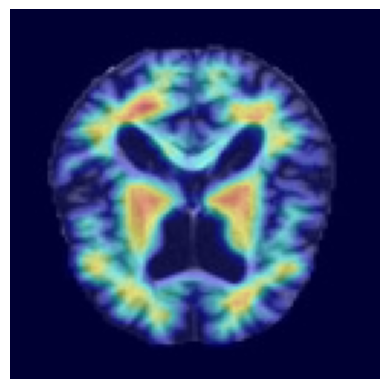

In [116]:
image_class = 'ModerateDemented'
dir = 'test'
target_class = 2

# Load an image and preprocess it
img_path = f'../data/alzheimer_mri/{dir}/{image_class}/{image_class}_6.png'
input_tensor = preprocess_image(img_path)

# Create Grad-CAM object for the last convolutional layer (layer4 in ResNet-50)
grad_cam = GradCam(model, target_layer='conv2')

# Generate Grad-CAM heatmap for the target class (optional, if not provided, it uses the predicted class)
heatmap = grad_cam(input_tensor,target_class)

# Overlay the heatmap on the original image
superimposed_img = overlay_heatmap(heatmap, img_path)

# Display the image with the heatmap
plt.imshow(superimposed_img[:, :, ::-1])  # Convert BGR to RGB for display
plt.axis('off')

# Save the plot
image_type = 'Real' if dir=='test' else 'Synthetic'
if target_class == 1:
    target = 'ModerateDemented' 
elif target_class == 2:
    target = 'NonDemented' 
plt.savefig(f'../thesis/figures/gradcam_images/{image_class}{image_type}Gradcam_predict{target}.jpg')

# Show the plot
plt.show()




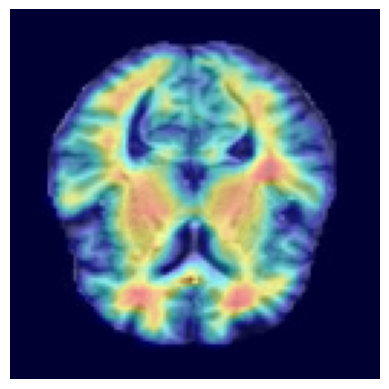

In [120]:
image_class = 'NonDemented'
dir = 'test'
target_class = 2

# Load an image and preprocess it
img_path = f'../data/alzheimer_mri/{dir}/{image_class}/{image_class}_100.png'
input_tensor = preprocess_image(img_path)

# Create Grad-CAM object for the last convolutional layer (layer4 in ResNet-50)
grad_cam = GradCam(model, target_layer='conv2')

# Generate Grad-CAM heatmap for the target class (optional, if not provided, it uses the predicted class)
heatmap = grad_cam(input_tensor,target_class)

# Overlay the heatmap on the original image
superimposed_img = overlay_heatmap(heatmap, img_path)

# Display the image with the heatmap
plt.imshow(superimposed_img[:, :, ::-1])  # Convert BGR to RGB for display
plt.axis('off')

# Save the plot
image_type = 'Real' if dir=='test' else 'Synthetic'
if target_class == 1:
    target = 'ModerateDemented' 
elif target_class == 2:
    target = 'NonDemented' 
plt.savefig(f'../thesis/figures/gradcam_images/{image_class}{image_type}Gradcam_predict{target}.jpg')

# Show the plot
plt.show()

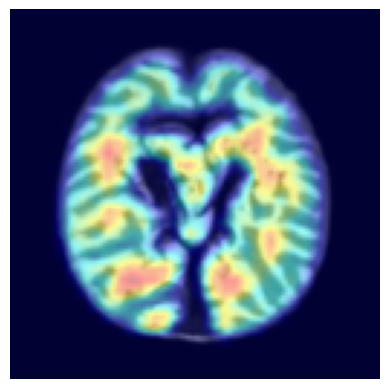

In [125]:
image_class = 'ModerateDemented'
dir = 'synthetic'
target_class = 2

# Load an image and preprocess it
img_path = '../data/alzheimer_mri/synthetic/ModerateDemented/ModerateDemented_6_generated16.png'
input_tensor = preprocess_image(img_path)

# Create Grad-CAM object for the last convolutional layer (layer4 in ResNet-50)
grad_cam = GradCam(model, target_layer='conv2')

# Generate Grad-CAM heatmap for the target class (optional, if not provided, it uses the predicted class)
heatmap = grad_cam(input_tensor,target_class)

# Overlay the heatmap on the original image
superimposed_img = overlay_heatmap(heatmap, img_path)

# Display the image with the heatmap
plt.imshow(superimposed_img[:, :, ::-1])  # Convert BGR to RGB for display
plt.axis('off')

# Save the plot
image_type = 'Real' if dir=='test' else 'Synthetic'
if target_class == 1:
    target = 'ModerateDemented' 
elif target_class == 2:
    target = 'NonDemented' 
plt.savefig(f'../thesis/figures/gradcam_images/{image_class}{image_type}Gradcam_predict{target}.jpg')

# Show the plot
plt.show()

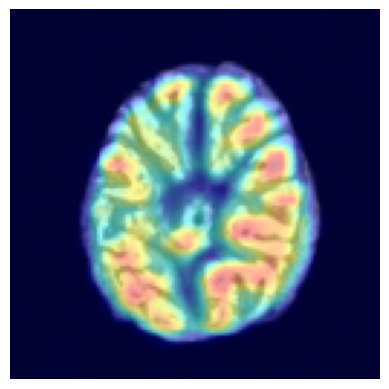

In [127]:
image_class = 'NonDemented'
dir = 'synthetic'
target_class = 2

# Load an image and preprocess it
img_path = '../data/alzheimer_mri/synthetic/NonDemented/NonDemented_100_generated7434.png'
input_tensor = preprocess_image(img_path)

# Create Grad-CAM object for the last convolutional layer (layer4 in ResNet-50)
grad_cam = GradCam(model, target_layer='conv2')

# Generate Grad-CAM heatmap for the target class (optional, if not provided, it uses the predicted class)
heatmap = grad_cam(input_tensor,target_class)

# Overlay the heatmap on the original image
superimposed_img = overlay_heatmap(heatmap, img_path)

# Display the image with the heatmap
plt.imshow(superimposed_img[:, :, ::-1])  # Convert BGR to RGB for display
plt.axis('off')

# Save the plot
image_type = 'Real' if dir=='test' else 'Synthetic'
if target_class == 1:
    target = 'ModerateDemented' 
elif target_class == 2:
    target = 'NonDemented' 
plt.savefig(f'../thesis/figures/gradcam_images/{image_class}{image_type}Gradcam_predict{target}.jpg')

# Show the plot
plt.show()